In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, silhouette_score, make_scorer
from sklearn.cluster import KMeans
import imageio.v3 as iio
import os
import shutil
from glob import glob
from sklearn.model_selection import GridSearchCV
from PIL import Image
from tqdm import tqdm
from time import time

In [2]:
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
assert x_mnist_train.shape == (60000, 28, 28)
assert x_mnist_test.shape == (10000, 28, 28)
assert y_mnist_train.shape == (60000,)
assert y_mnist_test.shape == (10000,)

x_mnist_train, x_mnist_test = x_mnist_train / 255.0, x_mnist_test / 255.0
x_mnist_train = x_mnist_train.reshape(x_mnist_train.shape[0], 28, 28, 1)
x_mnist_test = x_mnist_test.reshape(x_mnist_test.shape[0], 28, 28, 1)

x_mnist_train, x_mnist_val, y_mnist_train, y_mnist_val = train_test_split(x_mnist_train, y_mnist_train, test_size=0.25)

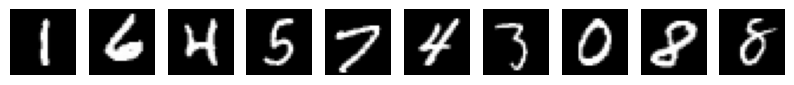

In [3]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(x_mnist_train[i], cmap="gray")
    ax.axis("off")

In [4]:
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()
assert x_fashion_train.shape == (60000, 28, 28)
assert x_fashion_test.shape == (10000, 28, 28)
assert y_fashion_train.shape == (60000,)
assert y_fashion_test.shape == (10000,)

x_fashion_train, x_fashion_test = x_fashion_train / 255.0, x_fashion_test / 255.0
x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], 28, 28, 1)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], 28, 28, 1)

x_fashion_train, x_fashion_val, y_fashion_train, y_fashion_val = train_test_split(x_fashion_train, y_fashion_train, test_size=0.25)

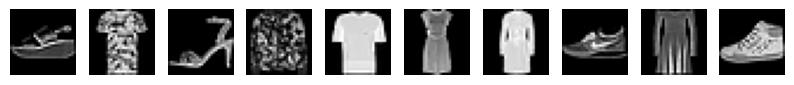

In [5]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(x_fashion_train[i], cmap="gray")
    ax.axis("off")

In [6]:
def create_model(input_shape, latent_dim):
    
    # --- Encoder ---
    inputs = Input(shape=input_shape)

    # Block 1 
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    # Block 2
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (2, 2), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    
    # Block 3
    x = Conv2D(16, (2, 2), activation="relu", padding="same")(x)
    x = Conv2D(4, (2, 2), activation="relu", padding="same")(x)
    x = Conv2D(1, (2, 2), activation="relu", padding="same")(x)
    
    # Latent space
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation="relu")(x)
    encoder = Model(inputs=inputs, outputs=encoded)
    encoded_inputs = Input(shape=(latent_dim,))

    # --- Decoder ---
    x = Dense(4, activation="relu")(encoded_inputs)
    x = Reshape((2, 2, 1))(x)
    
    # Block 1
    x = Conv2D(4, (2, 2), activation="relu", padding="same")(x)
    x = Conv2D(16, (2, 2), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((7, 7))(x)
    
    # Block 2
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    # Block 3
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
    decoder = Model(inputs=encoded_inputs, outputs=decoded)


    # --- Autoencoder ---
    x = encoder(inputs)
    x = decoder(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", "mse", "mae"]
    )
    
    return model, encoder, decoder

In [7]:
mnist_model, enc_mnist, dec_mnist = create_model(x_mnist_train.shape[1:], latent_dim=6)

In [8]:
enc_mnist.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        9248  

In [9]:
dec_mnist.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 28        
                                                                 
 reshape (Reshape)           (None, 2, 2, 1)           0         
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 4)           20        
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 16)          272       
                                                                 
 batch_normalization_2 (Batc  (None, 2, 2, 16)         64        
 hNormalization)                                                 
                                                           

In [10]:
mnist_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 6)                 35089     
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         42433     
                                                                 
Total params: 77,522
Trainable params: 77,298
Non-trainable params: 224
_________________________________________________________________


In [11]:
clr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=3,
    min_delta=0.01,
    cooldown=0,
    min_lr=1e-7,
    verbose=0,
)

In [12]:
es = EarlyStopping(
    monitor="loss",
    min_delta=0.01,
    patience=10,
    verbose=0,
)

In [47]:
mnist_history = mnist_model.fit(
    x_mnist_train, x_mnist_train,
    validation_data=(x_mnist_val, x_mnist_val),
    epochs=50,
    batch_size=256,
    callbacks=[clr, es],
)

Epoch 1/50
176/176 [==============================] - 9s 48ms/step - loss: 0.2454 - accuracy: 0.7968 - mse: 0.0612 - mae: 0.1383 - val_loss: 0.5936 - val_accuracy: 0.8084 - val_mse: 0.1074 - val_mae: 0.1322 - lr: 0.0010
Epoch 2/50
176/176 [==============================] - 8s 43ms/step - loss: 0.2301 - accuracy: 0.7954 - mse: 0.0564 - mae: 0.1281 - val_loss: 0.3050 - val_accuracy: 0.8063 - val_mse: 0.0758 - val_mae: 0.1361 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - 8s 43ms/step - loss: 0.2245 - accuracy: 0.7940 - mse: 0.0545 - mae: 0.1242 - val_loss: 0.2358 - val_accuracy: 0.7984 - val_mse: 0.0575 - val_mae: 0.1208 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - 8s 43ms/step - loss: 0.2122 - accuracy: 0.7938 - mse: 0.0507 - mae: 0.1163 - val_loss: 0.2294 - val_accuracy: 0.7869 - val_mse: 0.0564 - val_mae: 0.1187 - lr: 0.0010
Epoch 5/50
176/176 [==============================] - 8s 43ms/step - loss: 0.2063 - accuracy: 0.7944 - mse: 0.0488 - mae

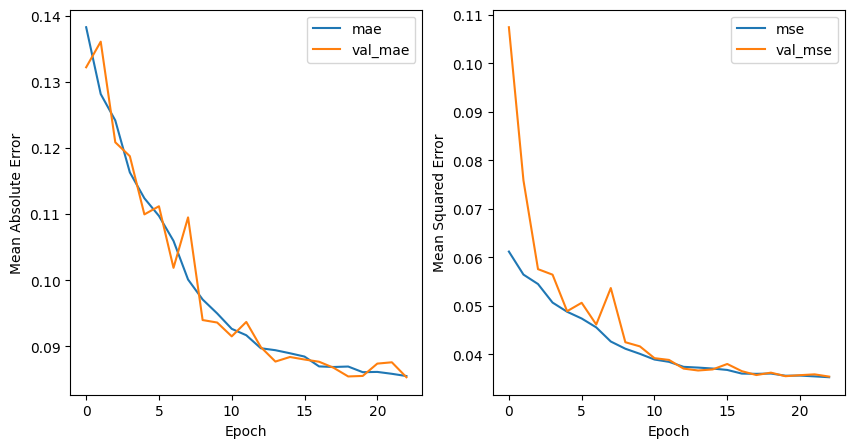

In [49]:
mae = mnist_history.history["mae"]
val_mae = mnist_history.history["val_mae"]

mse = mnist_history.history["mse"]
val_mse = mnist_history.history["val_mse"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(mae, label="mae")
axes[0].plot(val_mae, label="val_mae")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Mean Absolute Error")
axes[0].legend()


axes[1].plot(mse, label="mse")
axes[1].plot(val_mse, label="val_mse")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Mean Squared Error")
axes[1].legend()

plt.show()

In [52]:
test_loss, test_accuracy, test_mse, test_mae = mnist_model.evaluate(x_mnist_test, x_mnist_test, verbose=0)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test mse: {test_mse:.4f}")
print(f"Test mae: {test_mae:.4f}")

Test loss: 0.1671
Test accuracy: 0.7985
Test mse: 0.0354
Test mae: 0.0854


In [53]:
def get_sample_from_each_class(x, y):
    np.random.seed(int(time()))
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    x = x[shuffled_idx]
    y = y[shuffled_idx]
    samples = []
    for i in range(10):
        idx = np.where(y == i)[0][0]
        samples.append(x[idx])
    return np.array(samples)

In [54]:
def get_values(inputs, encoder, decoder):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs


def show_output(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2 * n, 5))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap="gray")
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap="gray")
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

1/1 [==============================] - 0s 16ms/step


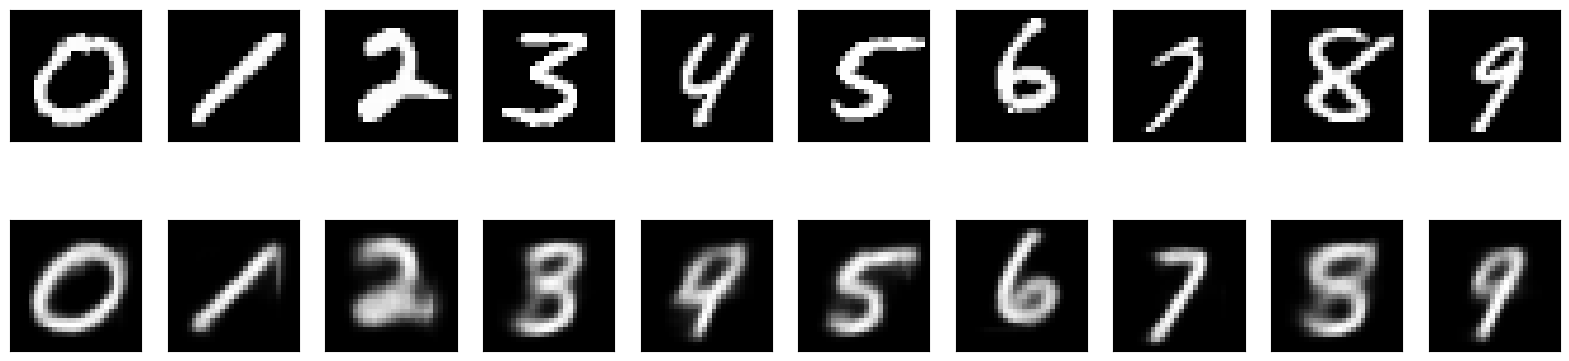

In [61]:
show_output(*get_values(get_sample_from_each_class(x_mnist_test, y_mnist_test), enc_mnist, dec_mnist))

In [13]:
fashion_model, enc_fashion, dec_fashion = create_model(x_fashion_train.shape[1:], latent_dim=6)

In [63]:
fashion_mnist_history = fashion_model.fit(
    x_fashion_train, x_fashion_train,
    validation_data=(x_fashion_val, x_fashion_val),
    epochs=50,
    batch_size=256,
    callbacks=[clr, es],
)

Epoch 1/50
176/176 [==============================] - 9s 48ms/step - loss: 0.4029 - accuracy: 0.4921 - mse: 0.0543 - mae: 0.1596 - val_loss: 0.5405 - val_accuracy: 0.5018 - val_mse: 0.1050 - val_mae: 0.2545 - lr: 0.0010
Epoch 2/50
176/176 [==============================] - 8s 43ms/step - loss: 0.3669 - accuracy: 0.4954 - mse: 0.0416 - mae: 0.1303 - val_loss: 0.4497 - val_accuracy: 0.4994 - val_mse: 0.0712 - val_mae: 0.1901 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - 8s 43ms/step - loss: 0.3584 - accuracy: 0.4966 - mse: 0.0387 - mae: 0.1234 - val_loss: 0.3951 - val_accuracy: 0.4895 - val_mse: 0.0504 - val_mae: 0.1472 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - 7s 42ms/step - loss: 0.3531 - accuracy: 0.4971 - mse: 0.0371 - mae: 0.1192 - val_loss: 0.3606 - val_accuracy: 0.5003 - val_mse: 0.0399 - val_mae: 0.1222 - lr: 0.0010
Epoch 5/50
176/176 [==============================] - 7s 41ms/step - loss: 0.3471 - accuracy: 0.4977 - mse: 0.0353 - mae

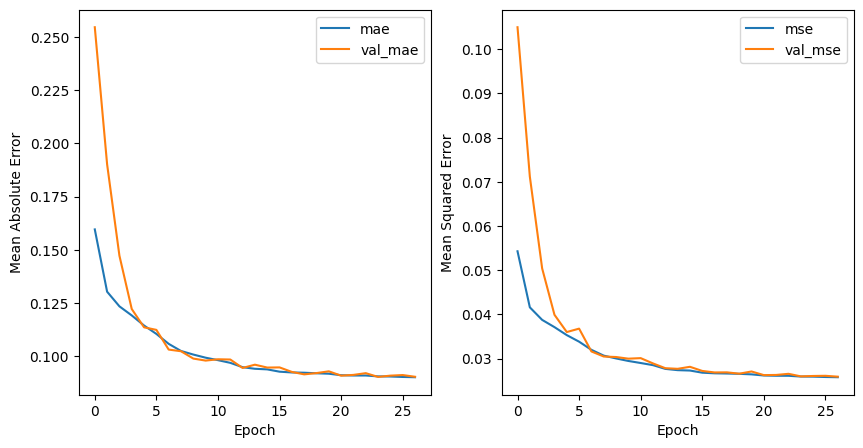

In [66]:
mae = fashion_mnist_history.history["mae"]
val_mae = fashion_mnist_history.history["val_mae"]

mse = fashion_mnist_history.history["mse"]
val_mse = fashion_mnist_history.history["val_mse"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(mae, label="mae")
axes[0].plot(val_mae, label="val_mae")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Mean Absolute Error")
axes[0].legend()


axes[1].plot(mse, label="mse")
axes[1].plot(val_mse, label="val_mse")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Mean Squared Error")
axes[1].legend()

plt.show()

In [67]:
test_loss, test_accuracy, test_mse, test_mae = fashion_model.evaluate(x_fashion_test, x_fashion_test, verbose=0)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test mse: {test_mse:.4f}")
print(f"Test mae: {test_mae:.4f}")

Test loss: 0.3186
Test accuracy: 0.4994
Test mse: 0.0258
Test mae: 0.0905


1/1 [==============================] - 0s 16ms/step


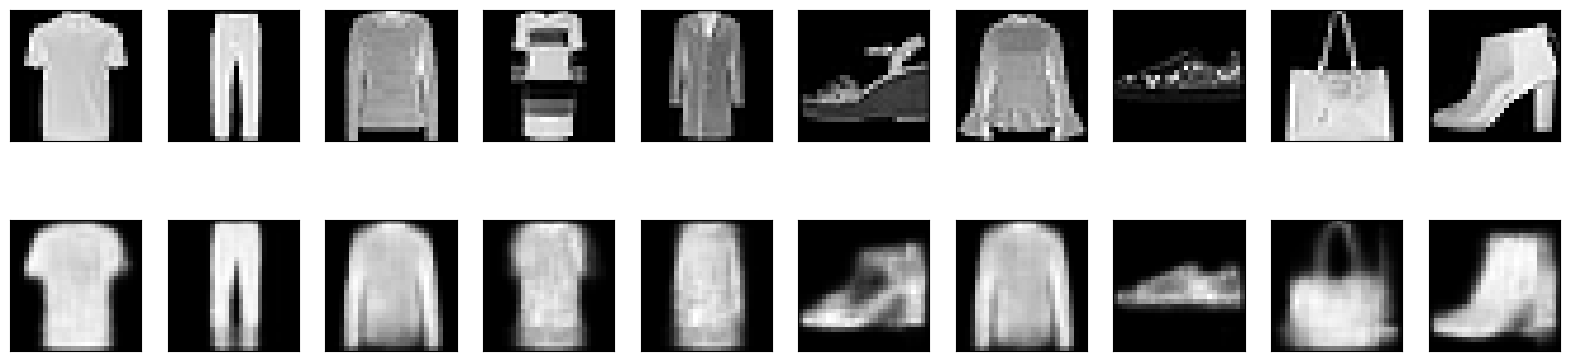

In [71]:
show_output(*get_values(get_sample_from_each_class(x_fashion_test, y_fashion_test), enc_fashion, dec_fashion))

In [69]:
mnist_model.save_weights("../models/mnist_autoencoder.h5")
with open("../models/mnist_autoencoder.json", "w") as f:
    f.write(mnist_model.to_json())
    
fashion_model.save_weights("../models/fashion_mnist_autoencoder.h5")
with open("../models/fashion_mnist_autoencoder.json", "w") as f:
    f.write(fashion_model.to_json())

In [14]:
# mnist_model = load_model("../models/mnist_autoencoder.json")
mnist_model.load_weights("../models/mnist_autoencoder.h5")

# fashion_mnist_model = load_model("../models/fashion_mnist_autoencoder.json")
fashion_model.load_weights("../models/fashion_mnist_autoencoder.h5")

In [15]:
x_mnist = np.concatenate([x_mnist_train, x_mnist_val, x_mnist_test], axis=0)
y_mnist = np.concatenate([y_mnist_train, y_mnist_val, y_mnist_test], axis=0)

x_fashion = np.concatenate([x_fashion_train, x_fashion_val, x_fashion_test], axis=0)
y_fashion = np.concatenate([y_fashion_train, y_fashion_val, y_fashion_test], axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

2188/2188 [==============================] - 4s 2ms/step


 10%|█         | 1/10 [01:12<10:52, 72.48s/it]

2188/2188 [==============================] - 4s 2ms/step


 20%|██        | 2/10 [02:27<09:50, 73.79s/it]

2188/2188 [==============================] - 4s 2ms/step


 30%|███       | 3/10 [03:28<07:55, 67.90s/it]

2188/2188 [==============================] - 3s 2ms/step


 40%|████      | 4/10 [04:29<06:31, 65.21s/it]

2188/2188 [==============================] - 4s 2ms/step


 50%|█████     | 5/10 [05:33<05:25, 65.06s/it]

2188/2188 [==============================] - 4s 2ms/step


 60%|██████    | 6/10 [06:36<04:16, 64.05s/it]

2188/2188 [==============================] - 3s 2ms/step


 70%|███████   | 7/10 [07:43<03:15, 65.16s/it]

2188/2188 [==============================] - 4s 2ms/step


 80%|████████  | 8/10 [08:46<02:08, 64.43s/it]

2188/2188 [==============================] - 3s 2ms/step


 90%|█████████ | 9/10 [09:49<01:03, 63.95s/it]

2188/2188 [==============================] - 4s 2ms/step


100%|██████████| 10/10 [10:54<00:00, 65.46s/it]


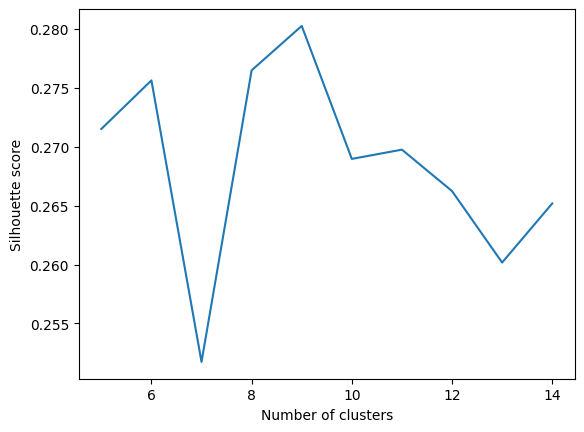

Optimal number of clusters for MNIST: 9


In [17]:
param_grid = {"n_clusters": np.arange(5, 15)}

silhouette_scores = []
for cluster in tqdm(param_grid["n_clusters"]):
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    kmeans.fit(enc_mnist.predict(x_mnist))
    silhouette_scores.append(silhouette_score(enc_mnist.predict(x_mnist), kmeans.labels_))

plt.plot(param_grid["n_clusters"], silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

print(f"Optimal number of clusters for MNIST: {param_grid['n_clusters'][np.argmax(silhouette_scores)]}")

kmeans_mnist = KMeans(n_clusters=param_grid["n_clusters"][np.argmax(silhouette_scores)], random_state=42)

  0%|          | 0/10 [00:00<?, ?it/s]

2188/2188 [==============================] - 4s 2ms/step


 10%|█         | 1/10 [01:04<09:36, 64.05s/it]

2188/2188 [==============================] - 3s 2ms/step


 20%|██        | 2/10 [02:08<08:34, 64.36s/it]

2188/2188 [==============================] - 4s 2ms/step


 30%|███       | 3/10 [03:14<07:36, 65.24s/it]

2188/2188 [==============================] - 4s 2ms/step


 40%|████      | 4/10 [04:20<06:31, 65.23s/it]

2188/2188 [==============================] - 4s 2ms/step


 50%|█████     | 5/10 [05:23<05:23, 64.60s/it]

2188/2188 [==============================] - 3s 2ms/step


 60%|██████    | 6/10 [06:25<04:15, 63.81s/it]

2188/2188 [==============================] - 4s 2ms/step


 70%|███████   | 7/10 [07:31<03:13, 64.46s/it]

2188/2188 [==============================] - 4s 2ms/step


 80%|████████  | 8/10 [08:35<02:08, 64.16s/it]

2188/2188 [==============================] - 3s 2ms/step


 90%|█████████ | 9/10 [09:39<01:04, 64.07s/it]

2188/2188 [==============================] - 3s 2ms/step


100%|██████████| 10/10 [10:41<00:00, 64.16s/it]


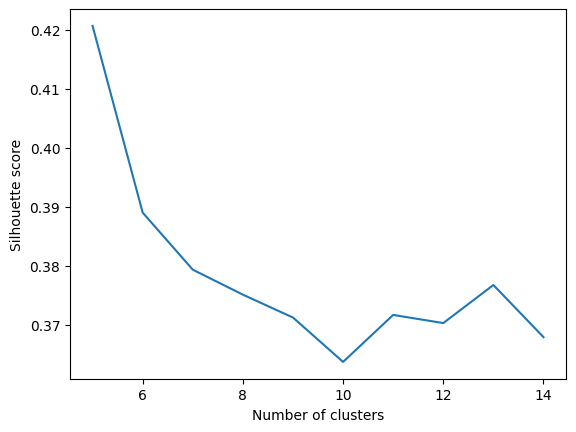

Optimal number of clusters for MNIST: 5


In [16]:
param_grid = {"n_clusters": np.arange(5, 15)}

silhouette_scores = []
for cluster in tqdm(param_grid["n_clusters"]):
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    kmeans.fit(enc_fashion.predict(x_fashion))
    silhouette_scores.append(silhouette_score(enc_fashion.predict(x_fashion), kmeans.labels_))

plt.plot(param_grid["n_clusters"], silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

print(f"Optimal number of clusters for MNIST: {param_grid['n_clusters'][np.argmax(silhouette_scores)]}")

kmeans_fashion = KMeans(n_clusters=param_grid["n_clusters"][np.argmax(silhouette_scores)], random_state=42)